<a href="https://colab.research.google.com/github/ESA-PhiLab/WorldCrops/blob/hopfield/colab_notebooks/Tsai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsai

     |████████████████████████████████| 180 kB 35.5 MB/s 
     |████████████████████████████████| 28.5 MB 49 kB/s 
     |████████████████████████████████| 23.1 MB 4.5 kB/s 
     |████████████████████████████████| 5.9 MB 24.1 MB/s 
     |████████████████████████████████| 189 kB 42.7 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 186 kB 60.5 MB/s 
     |████████████████████████████████| 3.4 MB 29.3 MB/s 
     |████████████████████████████████| 2.5 MB 30.6 MB/s 
     |████████████████████████████████| 72 kB 884 kB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 25.3 MB 87 kB/s 
     |████████████████████████████████| 9.5 MB 60.1 MB/s 
     |████████████████████████████████| 786 kB 42.8 MB/s 
     |████████████████████████████████| 1.1 MB 38.5 MB/s 
     |████████████████████████████████| 113 kB 70.9 MB/s 
     |████████████████████████████████| 123 kB 55.3 MB/s 
     |████████████████

In [ ]:
from tsai.all import *
computer_setup()

os             : Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.12
tsai           : 0.2.22
fastai         : 2.5.2
fastcore       : 1.3.26
torch          : 1.9.0+cu102
n_cpus         : 2
device         : cpu


In [ ]:
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/Training_bavaria.xlsx
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/Test_bavaria.xlsx
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/Test_area.shp
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/Test_area.shx

!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/data2016-2018.xlsx
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/TestData.xlsx

--2021-09-30 13:01:41--  https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/Training_bavaria.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6413030 (6.1M) [application/octet-stream]
Saving to: ‘Training_bavaria.xlsx’

Training_bavaria.xl 100%[===================>]   6.12M  --.-KB/s    in 0.04s   

2021-09-30 13:01:41 (165 MB/s) - ‘Training_bavaria.xlsx’ saved [6413030/6413030]

--2021-09-30 13:01:41--  https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/sentinel-2/Test_bavaria.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108

In [ ]:
bavaria_train = pd.read_excel(
    "Training_bavaria.xlsx")
bavaria_test = pd.read_excel(
    "Test_bavaria.xlsx")

bavaria_reordered = pd.read_excel(
    'data2016-2018.xlsx', index_col=0)
bavaria_test_reordered = pd.read_excel(
    'TestData.xlsx', index_col=0)

bavaria_test.drop(['Unnamed: 0'], axis=1, inplace=True)
bavaria_train.drop(['Unnamed: 0'], axis=1, inplace=True)

bavaria_train.Date = bavaria_train.Date.dt.strftime('%m-%d')

In [ ]:
n_fields = len(bavaria_train.id.unique())
n_days = 14
feature_list = bavaria_train.columns[bavaria_train.columns.str.contains("B", na=False)].tolist()

bavaria_train = bavaria_train.sort_values(by=['id', 'Date'])
arr = bavaria_train[feature_list].values.reshape(n_fields, n_days, len(feature_list) )
#switch timestemps and features axis -> (samples,features,timestemps)
X = np.swapaxes(arr, 1, 2)
y = bavaria_train['NC'].values.reshape(n_fields, n_days, 1 )
y = y[:,0,0]

#######
#Alternativ mit tsai aber funktioniert nicht richtig
######
# bringe es in -> (samples,features,timestamps): (2099,13,14)
data_col = bavaria_train.columns[bavaria_train.columns.str.contains("B", na=False)]

def y_func(o): return scipy.stats.mode(o, axis=1).mode
_, y_tsai = df2xy(bavaria_train, sample_col='id', target_col='NC', data_cols=['B1_mean'],sort_by='Date', to3d=True, y_func=y_func)

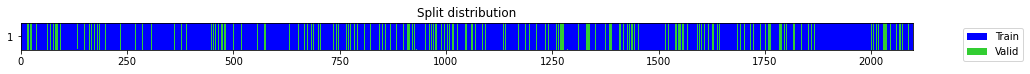

((#1680) [1071,1750,1304,842,1251,511,460,1620,229,2020...],
 (#419) [701,1391,64,1593,931,1292,1457,776,1189,307...])

In [ ]:
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits

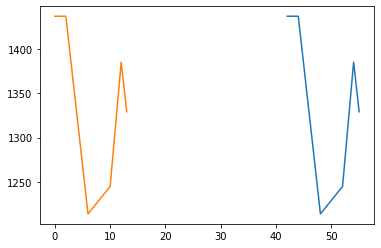

In [ ]:
bavaria_train[bavaria_train.id == 3]['B1_mean'].plot()
plt.plot(X[3,0,:])

X      - shape: [2099 samples x 13 features x 14 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (2099,)  type: ndarray  dtype:int64  isnan: 0
splits - n_splits: 2 shape: [1680, 419]  overlap: [False]


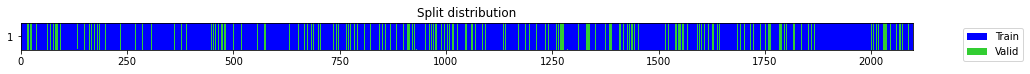

In [ ]:
# 100% train data
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
check_data(X, y, splits)
dls100 = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
udls100 = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms) # used in pretraining


X      - shape: [2099 samples x 13 features x 14 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (2099,)  type: ndarray  dtype:int64  isnan: 0
splits - n_splits: 2 shape: [168, 419]  overlap: [[879, 971, 604, 1146, 901, 852, 1022, 1582, 1336, 923, 475, 1235, 83, 1274, 1669, 34, 1360, 1638, 782, 520, 962, 85, 1067, 1311, 1588, 846, 912, 778, 1543, 376, 129, 25, 1609, 940, 1557, 930, 1407, 517]]


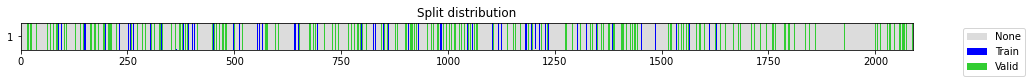

In [ ]:
# 10% train data
train_split010 = get_splits(y[splits[0]], valid_size=.1, show_plot=False)[1]
splits010 = (train_split010, splits[1])
check_data(X, y, splits010)
dls010 = get_ts_dls(X, y, splits=splits010, tfms=tfms, batch_tfms=batch_tfms)

9/10 accuracy: 0.734 +/- 0.022


epoch,train_loss,valid_loss,accuracy,time
0,3.292237,3.379596,0.028640,00:00
1,2.927632,3.337452,0.131265,00:00
2,2.612705,3.281652,0.243437,00:00
3,2.296895,3.184961,0.284010,00:00
4,1.999618,3.023403,0.372315,00:00
5,1.748685,2.686293,0.455847,00:00
6,1.571676,2.176485,0.362769,00:00
7,1.414034,2.138634,0.429594,00:00
8,1.281907,1.471937,0.565632,00:00
9,1.165695,1.384848,0.548926,00:00


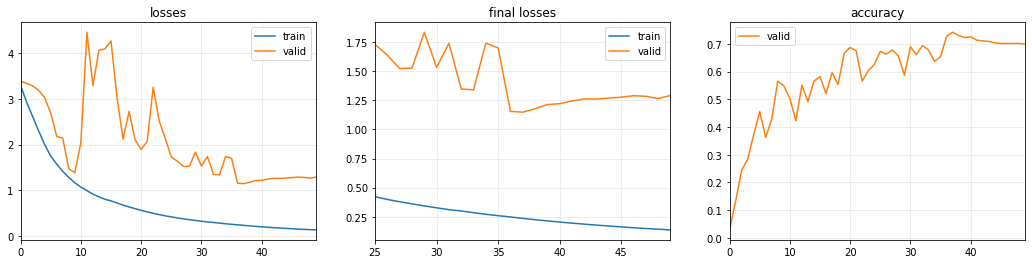


accuracy: 0.731 +/- 0.023 in 10 tests


In [ ]:
###############################
# Train supervised as benchmark
###############################


# supervised 10%
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.927 +/- 0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.773799,2.306757,0.496420,00:05
1,1.110224,0.761592,0.775656,00:05
2,0.820456,0.525339,0.842482,00:05
3,0.666392,0.543119,0.844869,00:05
4,0.557631,1.115832,0.675418,00:05
5,0.520427,0.762414,0.780430,00:05
6,0.464851,0.914090,0.747017,00:05
7,0.454068,1.063904,0.687351,00:05
8,0.424299,0.958960,0.763723,00:05
9,0.430204,0.702781,0.801909,00:05


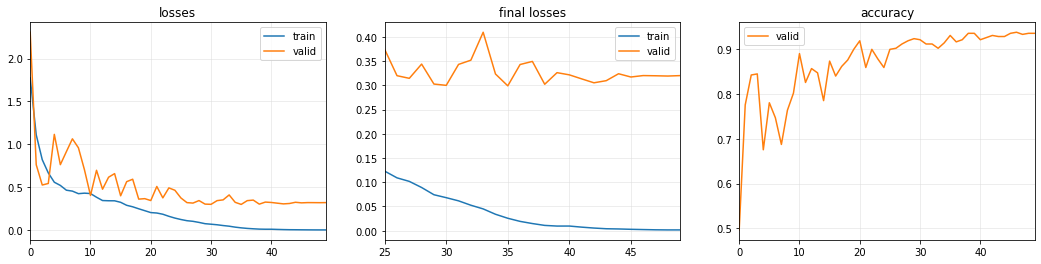


accuracy: 0.928 +/- 0.005 in 10 tests


In [ ]:
# supervised 100%
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

epoch,train_loss,valid_loss,time
0,0.661495,0.665566,00:06
1,0.434659,0.230748,00:05
2,0.319473,0.159069,00:05
3,0.251793,0.120121,00:05
4,0.203687,0.101190,00:05
5,0.171383,0.088129,00:05
6,0.147288,0.075493,00:05
7,0.129357,0.067181,00:05
8,0.114287,0.069987,00:05
9,0.103360,0.060181,00:05


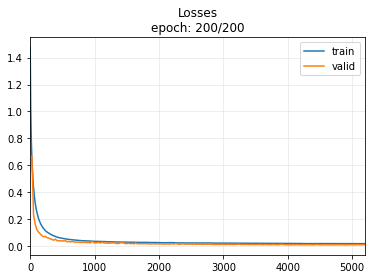


epochs: 200 best epoch: 187  val_loss: 0.006630 - pretrained weights_path='data/MVP/Test_Bavaria_200.pth'



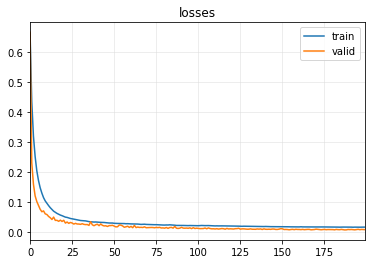

In [ ]:
###############################
# Train unsupervised 
###############################
# Unlabeled 100%
learn = ts_learner(udls100, InceptionTimePlus, cbs=[ShowGraph(), MVP(target_dir='./data/MVP', fname=f'Test_Bavaria_200')])
learn.fit_one_cycle(200, 1e-2)

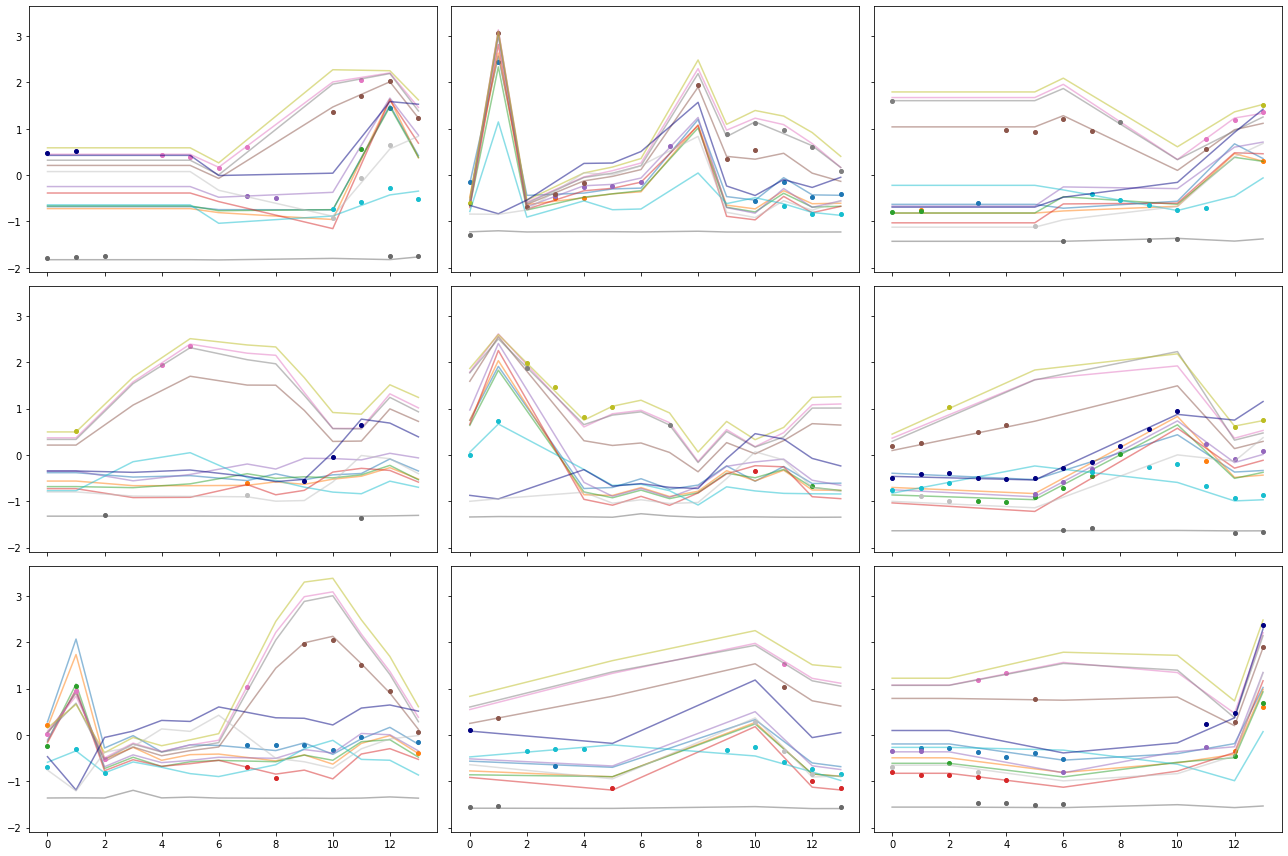

In [ ]:
learn.MVP.show_preds(sharey=True)

In [ ]:
learn = ts_learner(dls010, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/Test_Bavaria_200.pth', metrics=accuracy)
for p in learn.model.parameters():
    p.requires_grad=False
print(f'{"trainable params once manually frozen":40}: {count_parameters(learn.model):8}')
learn.freeze()
print(f'{"trainable params after learn.freeze()":40}: {count_parameters(learn.model):8}')
learn.unfreeze()
print(f'{"trainable params learn.unfreeze()":40}: {count_parameters(learn.model):8}')

weights from data/MVP/Test_Bavaria_200.pth successfully transferred!

trainable params once manually frozen   :        0
trainable params after learn.freeze()   :     5918
trainable params learn.unfreeze()       :   461022


In [ ]:
# self-supervised: fine-tuning with 10% labels
n_epochs = 50
freeze_epochs = 10
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/Test_Bavaria_200.pth', metrics=accuracy)
    learn.fine_tune(n_epochs, base_lr=2e-2, freeze_epochs=freeze_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

3/10 accuracy: 0.920 +/- 0.001
weights from data/MVP/Test_Bavaria_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,3.089838,2.778203,0.162291,00:03
1,2.682195,2.176172,0.202864,00:03
2,2.368226,1.919706,0.484487,00:03
3,2.123022,1.656841,0.565632,00:03
4,1.869689,1.333655,0.682578,00:03
5,1.601325,1.059712,0.723150,00:03
6,1.358092,0.867211,0.732697,00:03
7,1.138473,0.746333,0.747017,00:03
8,0.966539,0.683750,0.742243,00:03
9,0.826824,0.560254,0.849642,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.555557,0.543353,0.847255,00:05
1,0.543440,0.517439,0.856802,00:05
2,0.526729,0.514000,0.859189,00:05
3,0.515864,0.500714,0.871122,00:05
4,0.502477,0.491075,0.854415,00:05


(60, 1, 570)

(30, 1, 570)

In [ ]:
# 100% train data
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]

superv = get_ts_dls(X, y, tfms=tfms, batch_tfms=batch_tfms)
unsv = get_ts_dls(X, tfms=tfms, batch_tfms=batch_tfms) # used in pretraining


In [ ]:
# 10% train data
train_split010 = get_splits(y[splits[0]], valid_size=.1, show_plot=False)[1]
dls010 = get_ts_dls(X, y, tfms=tfms, batch_tfms=batch_tfms)


KeyError: ignored

In [ ]:
# supervised 10%
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')



0/10


NameError: ignored